In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow
!pip install n2v

In [ ]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

2.14.0
0.3.3


In [ ]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
import cv2
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import os

directory_path = "/content/drive/MyDrive/Colab Notebooks/data/N2V/png_images"

# Check if the directory exists and list its contents
if os.path.exists(directory_path):
    directory_contents = os.listdir(directory_path)
    print("Directory contents:")
    for item in directory_contents:
        print(item)
else:
    print("The specified directory does not exist.")


Directory contents:
NOISY_SRGB_010.PNG
median_rgb1.png
GT_SRGB_010.PNG
lady noisy.png


In [ ]:
datagen = N2V_DataGenerator()

In [ ]:
imgs = datagen.load_imgs_from_directory(directory = "/content/drive/MyDrive/Colab Notebooks/data/N2V/png_images",
                                        filter='*.png',dims='YXC')  #ZYX for 3D

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)

shape of loaded images:  (1, 328, 501, 4)
shape without alpha:     (1, 328, 501, 3)
The data type of the first image is:  float32


In [ ]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

2
(1, 328, 501, 3)
float32


In [ ]:
plt.figure()
plt.imshow(imgs[0][0,:,:,:])
plt.show()

In [ ]:
patch_size = 64

In [ ]:
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

Generated patches: (280, 64, 64, 3)
Generated patches: (400, 64, 64, 3)


In [ ]:
patches.shape

(680, 64, 64, 3)

In [ ]:
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [ ]:
print(X.shape)
print(X.dtype)
print(X_val.shape)


(544, 64, 64, 3)
float32
(136, 64, 64, 3)


Test Only![Don't run]

In [ ]:
datagen.generate_patches_from_list?

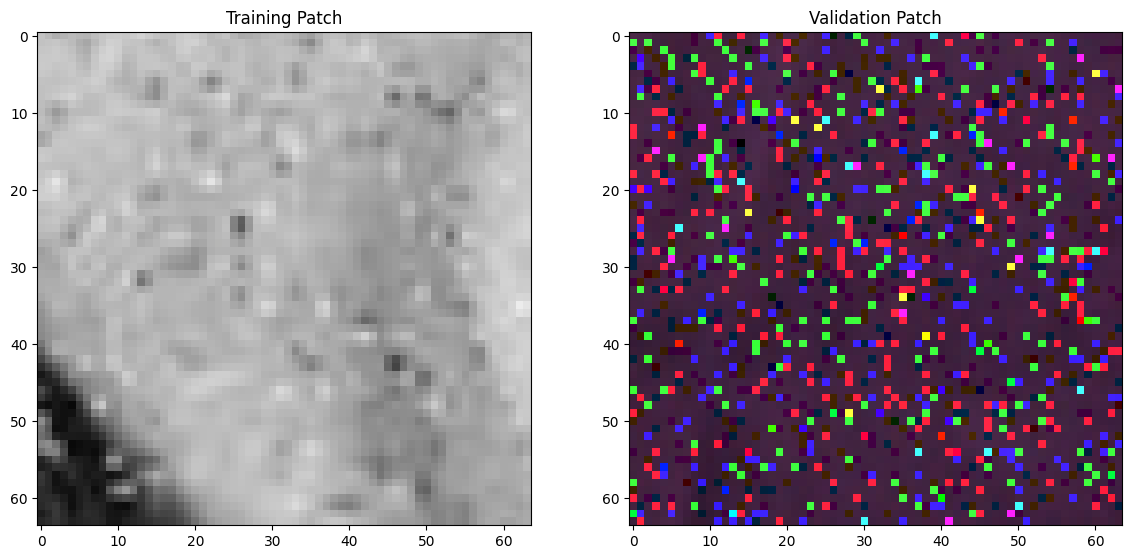

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

In [ ]:
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

In [ ]:
model_name = 'n2v_2D_stars'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)


In [ ]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 136/136 [00:00<00:00, 807.38it/s]


Epoch 1/20
17/17 [==============================] - 16s 322ms/step - loss: 0.6706 - n2v_mse: 0.6706 - n2v_abs: 0.5858 - val_loss: 0.8564 - val_n2v_mse: 0.8327 - val_n2v_abs: 0.7961 - lr: 4.0000e-04
Epoch 2/20
17/17 [==============================] - 3s 191ms/step - loss: 0.2611 - n2v_mse: 0.2611 - n2v_abs: 0.3276 - val_loss: 0.7363 - val_n2v_mse: 0.7158 - val_n2v_abs: 0.7179 - lr: 4.0000e-04
Epoch 3/20
17/17 [==============================] - 3s 159ms/step - loss: 0.2107 - n2v_mse: 0.2107 - n2v_abs: 0.2646 - val_loss: 0.6798 - val_n2v_mse: 0.6610 - val_n2v_abs: 0.6748 - lr: 4.0000e-04
Epoch 4/20
17/17 [==============================] - 3s 162ms/step - loss: 0.2176 - n2v_mse: 0.2176 - n2v_abs: 0.2849 - val_loss: 0.6409 - val_n2v_mse: 0.6245 - val_n2v_abs: 0.6520 - lr: 4.0000e-04
Epoch 5/20
17/17 [==============================] - 3s 178ms/step - loss: 0.1970 - n2v_mse: 0.1970 - n2v_abs: 0.2570 - val_loss: 0.6030 - val_n2v_mse: 0.5890 - val_n2v_abs: 0.6321 - lr: 4.0000e-04
Epoch 6/20
17/

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


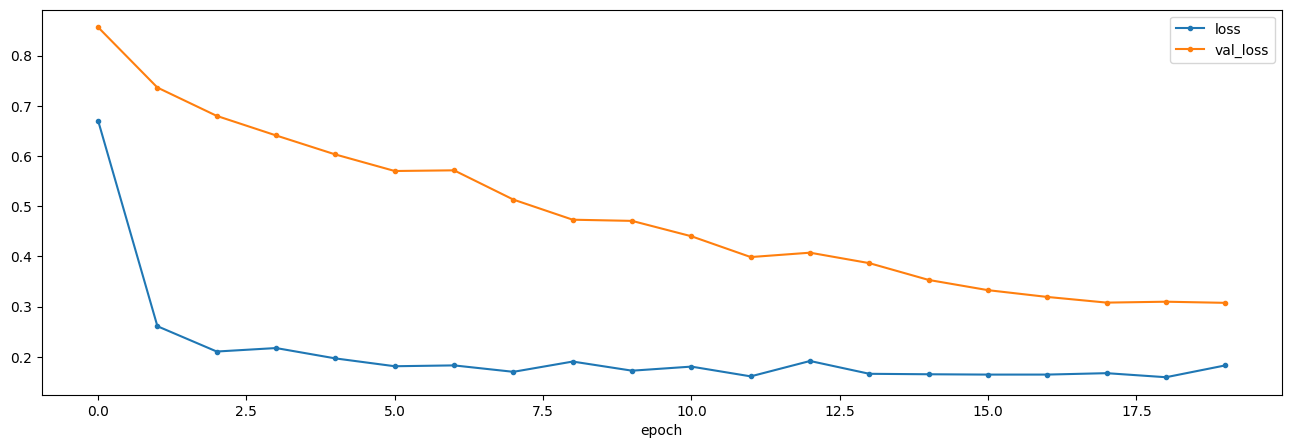

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [ ]:
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [ ]:
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [ ]:
img = imread("/content/drive/MyDrive/Colab Notebooks/data/N2V/png_images/GT_SRGB_010.PNG")
img.dtype

dtype('float32')

In [ ]:
pred = model.predict(img, axes='YXC')

Out of memory, retrying with n_tiles = (1, 2, 1)
1/1 [==============================] - 0s 389ms/step


 50%|█████     | 1/2 [00:00<00:00, 49932.19it/s]

1/1 [==============================] - 0s 106ms/step


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


In [ ]:
pred.shape

(3000, 5328, 3)

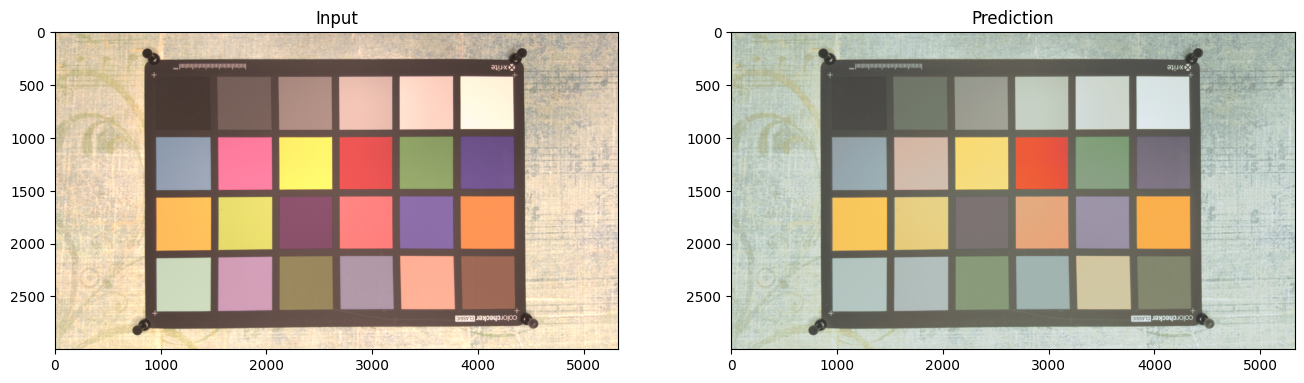

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');

In [ ]:
save_tiff_imagej_compatible('pred_train.tif', pred, axes='YXC')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Load the ground truth image (clean image without noise)
gt_img = imread("/content/drive/MyDrive/Colab Notebooks/data/N2V/png_images/GT_SRGB_010.PNG")

# Calculate SSIM
ssim_value = structural_similarity(gt_img, pred, multichannel=True)
print("SSIM:", ssim_value)
# Calculate PSNR
psnr_value = peak_signal_noise_ratio(gt_img, pred)
print("PSNR:",psnr_value)




<ipython-input-153-13245fe8eb0d>:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = structural_similarity(gt_img, pred, multichannel=True)


SSIM:0.289949
PSNR:31.1111113
